In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

class BilinearModified(nn.Module):
    def __init__(self, in1_features, in2_features, out_features, bias=True, device=None):
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.empty(out_features, in1_features, in2_features, device=device))

        if bias:
            self.register_buffer("bias", torch.tensor([-70.0], device=device))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / np.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)

        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, x1, x2):
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0
        return F.bilinear(x1, x2, self.weight, self.bias)

class DBNN_F(nn.Module):
    """
    FFT 版本：输出与 DBNN 中的 conv1d 实现严格对齐：
    y = conv1d(x, flip(kernels), groups=N, padding=T-1)[:, :, :T]
      ≡ full convolution of x with kernels（未翻转）取前 T 个点
    """
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN_F, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device

        # parameters（和 DBNN 一致）
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions, device=device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions, device=device) * 200)
        self.omega    = nn.Parameter(torch.ones(num_dimensions, device=device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1, device=device).to(device)

    def create_kernels(self):
        # 和 DBNN 完全相同
        T = torch.arange(self.time_dur, device=self.device)
        tau_rise  = self.tau_rise.unsqueeze(1)   # (N,1)
        tau_decay = self.tau_decay.unsqueeze(1)  # (N,1)
        omega     = self.omega.unsqueeze(1)      # (N,1)

        kernels = omega * (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
        return kernels.unsqueeze(1)  # (N,1,T)

    def forward(self, x):
        """
        x: (B, N, T)
        目标：用 FFT 实现
        y = conv1d(x, flip(kernels), groups=N, padding=T-1)[:, :, :T]
          ≡ 对每个通道做 full convolution: x_i * k_i（未翻转），取前 T 个点
        """
        B, N, T = x.shape
        assert N == self.num_dimensions
        assert T == self.time_dur

        # ---- 生成 kernel（注意：这里不再 flip） ----
        kernels = self.create_kernels()           # (N,1,T)
        k = kernels.squeeze(1)                    # (N,T)

        # ---- FFT 实现 full convolution ----
        # full conv 长度 = T + T - 1
        L_full = 2 * T - 1
        # 选择一个 >= L_full 的 FFT 长度（2 的幂，有利于加速）
        fft_size = 1 << (L_full - 1).bit_length()

        # 对时间维做 FFT
        # X_fft: (B, N, F)
        X_fft = torch.fft.rfft(x, n=fft_size, dim=2)
        # K_fft: (N, F)
        K_fft = torch.fft.rfft(k, n=fft_size, dim=1)

        # 广播相乘： (B,N,F) * (1,N,F) -> (B,N,F)
        Y_fft = X_fft * K_fft.unsqueeze(0)

        # 反变换得到 full convolution，长度至少 L_full
        y_full = torch.fft.irfft(Y_fft, n=fft_size, dim=2)[..., :L_full]  # (B,N,L_full)

        # DBNN 里：conv1d(..., padding=T-1) 的结果就是这个 full conv，
        # 然后取前 T 个时间点
        y = y_full[..., :T]  # (B,N,T)

        # ---- 后续和 DBNN 完全一致 ----
        y_perm = y.permute(0, 2, 1)  # (B,T,N)
        bilinear_term = self.bilinear(y_perm, y_perm)         # (B,T,1)
        linear_term   = torch.sum(y_perm, dim=2).unsqueeze(-1)  # (B,T,1)

        return (bilinear_term + linear_term).squeeze(-1)  # (B,T)

    

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 200)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

model_F = DBNN_F(10, 1000, torch.device('cpu'))
model = DBNN(10, 1000, torch.device('cpu'))
# 把参数拷过去，确保两边完全一致
with torch.no_grad():
    model_F.tau_rise.copy_(model.tau_rise)
    model_F.tau_decay.copy_(model.tau_decay)
    model_F.omega.copy_(model.omega)
    model_F.bilinear.weight.copy_(model.bilinear.weight)

def generate_poisson_input(nd, td, freq, device, batch_size=1):
    dt = 1.0
    p = (freq / 1000.0) * dt
    return (torch.rand(batch_size, nd, td, device=device) < p).float()

x = generate_poisson_input(10, 1000, 10, torch.device('cpu'))

y_F = model_F(x)
y = model(x)
print("max abs diff:", (y - y_F).abs().max().item())

max abs diff: 1.52587890625e-05


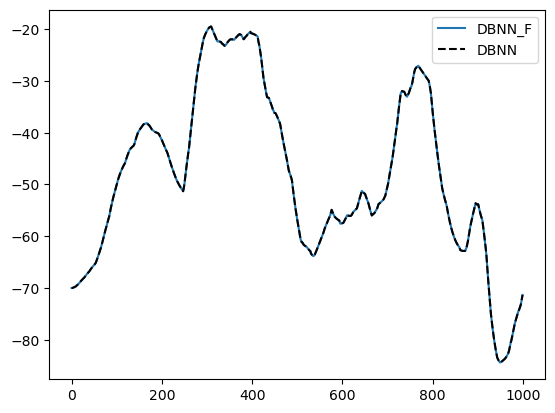

In [27]:
plt.plot(y_F.detach().numpy().flatten(), label='DBNN_F')
plt.plot(y.detach().numpy().flatten(), c='black', ls='--', label='DBNN')
plt.legend()